In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans

In [2]:
sns.set(style="ticks")
sns.set_palette("colorblind")
# TODO
mpl.rcParams['font.size'] = 9 # This should set the size to 9pt
# TODO remove size
# newly added:
# matplotlib.rcParams['figure.dpi'] = 300  # @669

# max width=6in @682
# max height=8in @682

In [3]:
# Set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)

# 1. Question – What makes a Munro popular?

In [4]:
# Load dataset
munro = pd.read_csv('datasets/clean.csv')
munro.head()

,name,altitude,ascent_count,rating,region,report_count,rating_count,bb_count,hotel_count,hostel_count,...,neighbor_count_0_5,neighbor_count_5_20,nearest_city_dist,nearest_city_population,population_0_25,population_25_50,population_50_75,population_75_100,beginner_friendly,national_park
0,Ben Nevis,1345,17902,3.84,Fort William,316,253,72,41,18,...,5,24,6.68,10459,10459,0,8575,223189,0,NaN
1,Ben Macdui,1309,10449,3.78,Cairngorms,215,162,37,29,9,...,7,13,56.26,70000,0,0,158093,604889,0,Cairngorms
2,Braeriach,1296,6035,3.95,Cairngorms,141,94,37,29,9,...,3,17,53.49,70000,0,0,150894,612088,0,Cairngorms
3,Cairn Toul,1291,5121,3.86,Cairngorms,136,83,37,29,9,...,6,15,56.30,70000,0,0,205053,566929,0,Cairngorms
4,Sgor an Lochain Uaine,1258,4832,3.83,Cairngorms,139,79,37,29,9,...,6,14,55.43,70000,0,0,158093,613889,0,Cairngorms


### 1. Visualise the distribution of Munro heights and frequency of them being climbed

#### Distribution of number of ascents

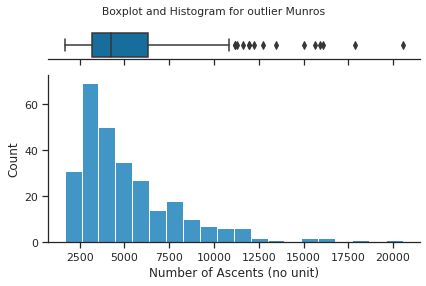

In [5]:
_, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(6, 4))

# Box plot
sns.boxplot(x=munro['ascent_count'], ax=ax_box)
sns.despine(ax=ax_box, left=True)  # Remove border
ax_box.get_yaxis().set_visible(False)
ax_box.set_xlabel(None)

# Histogram
sns.histplot(munro['ascent_count'], ax=ax_hist, bins='fd')
sns.despine(ax=ax_hist)  # Remove border
ax_hist.set_ylabel('Count')
ax_hist.set_xlabel('Number of Ascents (no unit)')

plt.suptitle('Boxplot and Histogram for outlier Munros')
plt.tight_layout()

plt.savefig("ascent_distribution.pdf", dpi=300)

plt.show()

The boxplot indicates that, in terms of number of ascents, an outlier is any Munro for which the number of ascents is above ~11,000. We now determine this value exactly:

In [6]:
# Code snippet adapted from: https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot
Q1 = munro['ascent_count'].quantile(0.25)
Q3 = munro['ascent_count'].quantile(0.75)
IQR = Q3 - Q1 # Interquartile range

cutoff_ascent_count = Q3 + 1.5 * IQR
cutoff_ascent_count = int(cutoff_ascent_count.round(0))  # Round to the nearest integer
print('Cutoff ascent count for outlier:  {}'.format(cutoff_ascent_count))

Cutoff ascent count for outlier:  11018


#### Distribution of altitude

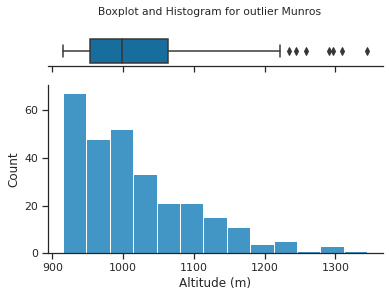

In [7]:
_, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(6,4))

# Box plot
sns.boxplot(x=munro['altitude'], ax=ax_box)
sns.despine(ax=ax_box, left=True)  # Remove border
ax_box.get_yaxis().set_visible(False)
ax_box.set_xlabel(None)

# Histogram
sns.histplot(munro['altitude'], ax=ax_hist, bins='fd')
sns.despine(ax=ax_hist)  # Remove border
ax_hist.set_ylabel('Count')
ax_hist.set_xlabel('Altitude (m)')

plt.suptitle('Boxplot and Histogram for outlier Munros')

plt.savefig("altitude_distribution.pdf")

plt.show()

The boxplot indicates that, in terms of altitude, an outlier is any Munro with a height above ~1250m. Again, we determine this value exactly:

In [8]:
# Code snippet adapted from: https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot
Q1 = munro['altitude'].quantile(0.25)
Q3 = munro['altitude'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

cutoff_altitude = Q3 + 1.5 * IQR
cutoff_altitude = int(cutoff_altitude.round(0))  # Round to the nearest integer
print('Cutoff altitude for outlier:  {}'.format(cutoff_altitude))

Cutoff altitude for outlier:  1229


#### Joint distribution of altitude and ascent count

We wish to get a summary view of both variables at once. To that end, we plot the joint distribution of altitude and ascent.

<Figure size 432x288 with 0 Axes>

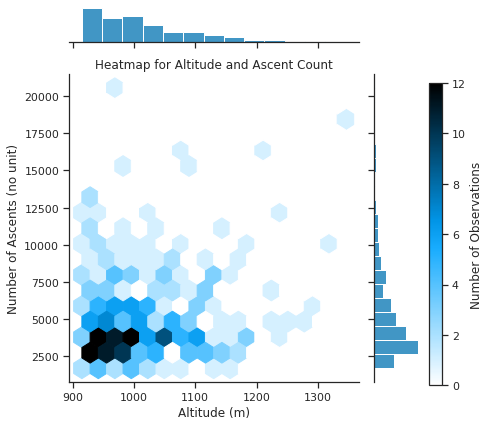

In [9]:
plt.figure(figsize=(6,4))

# Joint distribution
ax = sns.jointplot(x='altitude', y='ascent_count', data=munro, kind='hex')
plt.ylabel('Number of Ascents (no unit)')
plt.xlabel('Altitude (m)')
plt.title('Heatmap for Altitude and Ascent Count')
plt.tight_layout()

# Add colorbar
cbar_ax = ax.fig.add_axes([1, 0.1, .03, .7])
cb = plt.colorbar(cax=cbar_ax)
cb.set_label('Number of Observations')

plt.savefig("heatmap_joint_distribution.pdf")

plt.show()

The above plot tells us that the majority of Munros has an altitude between 900 and 1000m, and an ascent count of 2500 to 3000. As we previously noted, there are apparent outliers. We treat these below:

### 2. Identify outliers and reason about them
Note: also refer to Google docs

In [10]:
# Separate outliers and non-outliers
mask_outliers = (munro['ascent_count'] <= cutoff_ascent_count) & (munro['altitude'] <= cutoff_altitude)
df_no_outliers = munro.loc[mask_outliers]
df_outliers = munro.loc[~mask_outliers]

In [11]:
# Note for Tudor: the below two cells are merely there to help you notice any other apparent outliers besides Ben Nevis and Lomond

In [12]:
df_outliers['name']

0                      Ben Nevis
1                     Ben Macdui
2                      Braeriach
3                     Cairn Toul
4          Sgor an Lochain Uaine
5                     Cairn Gorm
6      Aonach Beag (Nevis Range)
9                     Ben Lawers
20                     Lochnagar
46                   Beinn Ghlas
57                  Schiehallion
117                    Beinn Ime
164      Ben Vorlich (Loch Earn)
183                   Ben Lomond
218                       Driesh
246                The Cairnwell
249                  Ben Chonzie
252                        Mayar
258                Beinn Narnain
277                   Carn Aosda
Name: name, dtype: object

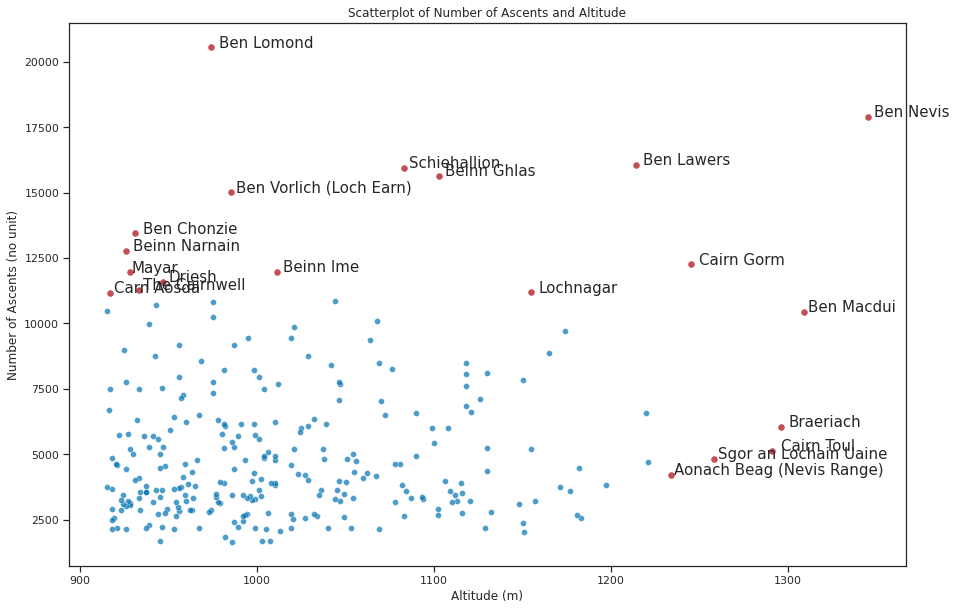

In [13]:
# DO NOT INCLUDE THIS PLOT!!!!!!!
def show_outlier(row):
    plt.scatter(row['altitude'], row['ascent_count'], c='r', s=30)
    # Annotate outlier, add random noise to x,y coordinates to remedy overlaps
    plt.annotate(row['name'], (row['altitude']+np.random.uniform(5), row['ascent_count']+np.random.uniform(20)), size=15)

plt.figure(figsize=(15,10))
sns.scatterplot(x='altitude', y='ascent_count', data=df_no_outliers, alpha = 0.7)

# Annotate outliers
df_outliers.apply(show_outlier, axis=1)

plt.title('Scatterplot of Number of Ascents and Altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Number of Ascents (no unit)')
plt.show()

In [14]:
# Note for Tudor: official work continues from here

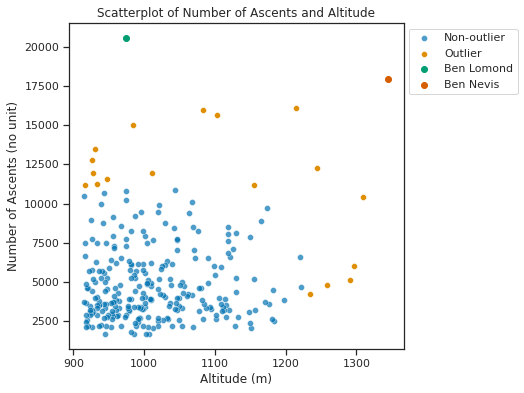

In [15]:
plt.figure(figsize=(6,6))

# Plot regular
sns.scatterplot(x='altitude', y='ascent_count', data=df_no_outliers, label='Non-outlier', alpha = 0.7)

# Plot outliers
sns.scatterplot(x='altitude', y='ascent_count', data=df_outliers, label='Outlier')

# Plot identified outliers
for identified_outlier in ['Ben Lomond', 'Ben Nevis']:  # TODO: for Tudor: please add more specific outliers if you notice any, thanks.
    b = munro.loc[munro['name'] == identified_outlier]
    plt.scatter('altitude', 'ascent_count', data=b, label=identified_outlier)

plt.title('Scatterplot of Number of Ascents and Altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Number of Ascents (no unit)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig("scatterplot.pdf", bbox_inches='tight') # set bbox_inches to tight to prevent the legend from being cropped

plt.show()

There are some noticeable outliers. However, as the <insert reasoning\> about e.g. Ben Nevis or Ben Lomond shows, it is completely possible to attain these datapoints. They are therefore valid and shall be included in our statistical analysis.

### 3. Is there a statistically significant relationship between height and frequency of climb?

Note: we do not work with frequency of climb, but rather with the number of climbs.
Judging by the above scatterplot, there appears to be no apparent, strong relationship between said variables. However, the outliers (e.g. Ben Nevis) exert a leverage and we expect to see a positive relationship between number of ascents and altitude. Our conclusions will be marred due to the large variance in the left-hand side of the scatterplot.

<!-- lmk what you think about the wording please, ofc please correct anything that's off, thank you -->

Define the null and alternate hypotheses:

$H_0$ = there is _not_ a statistically significant relationship between altitude and number of ascents.

$H_a$ = there _is_ a statistically significant relationship between altitude and number of ascents.

We apply linear regression and observe the output of `statsmodels`. This will show us whether the relationship between ascent couunt and altitude could be due to chance.

In [16]:
# Fit model
model = smf.ols('ascent_count ~ altitude', data=munro)
results = model.fit()

In [17]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ascent_count   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.351
Date:                Sat, 03 Apr 2021   Prob (F-statistic):             0.0214
Time:                        15:27:01   Log-Likelihood:                -2656.6
No. Observations:                 282   AIC:                             5317.
Df Residuals:                     280   BIC:                             5324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    209.0351   2179.614      0.096      0.9

The second error message indicates that there is numerical instability (multicollinearity is out of question as there is a single predictor). We remedy this by centering the independent variable around 0: (TODO: better explanation)

In [18]:
munro_mod = munro.copy()
munro_mod['altitude'] = munro_mod['altitude'] - munro_mod['altitude'].mean()  # center the values around 0 on the x-axis
# Fit model
model = smf.ols('ascent_count ~ altitude', data=munro_mod)
results = model.fit()

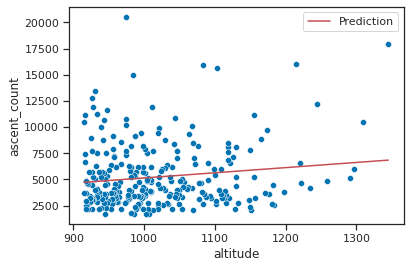

                            OLS Regression Results                            
Dep. Variable:           ascent_count   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.351
Date:                Sat, 03 Apr 2021   Prob (F-statistic):             0.0214
Time:                        15:27:05   Log-Likelihood:                -2656.6
No. Observations:                 282   AIC:                             5317.
Df Residuals:                     280   BIC:                             5324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5233.8865    178.412     29.336      0.0

In [19]:
sns.scatterplot(data=munro, y='ascent_count', x='altitude')
y_hat = results.predict(munro_mod['altitude'])  # Predicted data
sns.lineplot(x=munro['altitude'], y=y_hat, color='r', label='Prediction')

# plt.suptitle('Prediction Over Raw Data')
plt.legend()
plt.savefig('q1_prediction.pdf', bbox_inches='tight')
plt.show()

print(results.summary())

- The $p$-value tells us that there is a 2% probability that the relationship between altitude and ascent count may be due to chance. Since 0.021 < 0.05, it allows us to reject the null hypothesis that the coefficient of altitude in the model equals 0 at the 5% level. Furthermore, the t score is fairly high too, to further assert our claim. Thus, there is a statistically significant relationship between altitude and ascent count.
- However,we observe that the $R^2$ value is quite low at 0.019. This tells us that the model does not fit the data too well. This motivates the use of further predictors to aid our analysis.
- Since we standardised the independent variable (i.e. it has mean 0), the intercept tells us the expected ascent count for a Munro of mean altitude.
- NEW: The coefficient of altitude tells us that each extra meter of altitude leads to ~5 ascents. The confidence interval tells us that in 95% of all samples that could be drawn, \[0.736, 9.138\] will include the true value of the coefficient for altitude.

In [20]:
# RMSE and MSE
# TODO: relative measure of error?
print('MSE: {}'.format(results.mse_total))
print('RMSE:  {}'.format(np.sqrt(results.mse_total)))

MSE: 9115233.844728805
RMSE:  3019.1445551229913


The root mean square error indicates how far predictions of ascent count deviate from actual observed values, in absolute terms. The RMSE tells us that this deviation is about 3000. Given that the mean ascent count is approximately 5200, this is a relatively large deviation.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


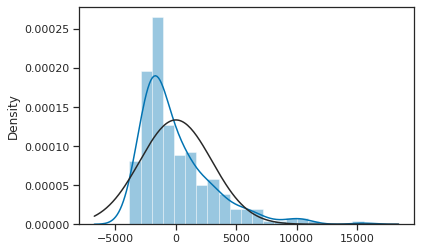

In [21]:
# Plot the distribution of residuals
sns.distplot(results.resid, fit=stats.norm)
plt.savefig('residuals_dist.pdf', bbox_inches='tight')
# plt.title('Distribution of Residuals')
plt.show()

A good Linear regression fit requires the residuals to be normally distributed. This is not exactly a normal distribution, and is fairly skewed. This is not what we are looking for. 

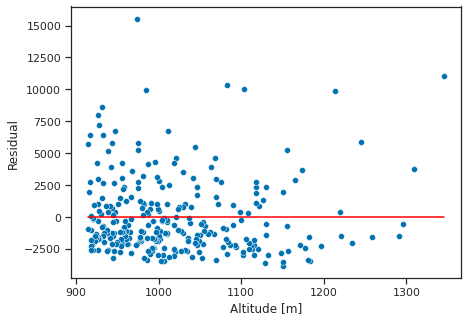

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = sns.scatterplot(x=munro['altitude'], y=results.resid)

ax.set_ylabel('Residual')
ax.set_xlabel('Altitude [m]')
# ax.set_title('Residual Plot')

sns.lineplot(x=munro['altitude'], y=0, color='red')

plt.savefig('residuals_plot.pdf', bbox_inches='tight')
plt.show()

The plot is not heteroskedastic. There is no obvious pattern observed – the independent variable and variance do not exhibit a relationship. Therefore, a linear model is not a bad choice.

### 4. How much can we trust the conclusions given the nature of the data?

Refer to notes in google docs

## 2. Question – Identify other factors

We only pick continuous features here, since the feature selection technique expects continuous features. This means we have ignored columns which have categorical and boolean data. In addition, we ignore `rating_count`, since it is not an inherent property of a Munro, and learning about its importance wouldn't provide useful insight. Lastly, we also removed `ascent_count` as it is the dependent variable of the statistical problem at hand.

In [23]:
irrelevant_cols = ['name', 'ascent_count', 'rating', 'region', 'report_count', 
                    'rating_count', 'island', 'county', 'latitude', 'longitude']
boolean_cols = ['beginner_friendly']
categorical_cols = ['national_park', 'island']

# We only apply pca to continuous variables
irrelevant_cols.extend(boolean_cols)
irrelevant_cols.extend(categorical_cols)

munro_subset = munro.loc[:, ~munro.columns.isin(irrelevant_cols)]
munro_subset.head()

,altitude,bb_count,hotel_count,hostel_count,cottage_count,camping_count,neighbor_count_0_5,neighbor_count_5_20,nearest_city_dist,nearest_city_population,population_0_25,population_25_50,population_50_75,population_75_100
0,1345,72,41,18,147,147,5,24,6.68,10459,10459,0,8575,223189
1,1309,37,29,9,182,182,7,13,56.26,70000,0,0,158093,604889
2,1296,37,29,9,182,182,3,17,53.49,70000,0,0,150894,612088
3,1291,37,29,9,182,182,6,15,56.30,70000,0,0,205053,566929
4,1258,37,29,9,182,182,6,14,55.43,70000,0,0,158093,613889


## Standardize data

Now that we have our subset data with all relevant features, we will standardize the dataset to make sure that the data can effectively undergo statistical analysis. This will help with numerical stability because features in `munro_subset` have different range of values (e.g. population can be in the thousands, whereas hotel_count is in the tens). As a result, we decided to go ahead with Scikit Learn's StandardScaler class.

In [24]:
standardized_data = StandardScaler().fit_transform(munro_subset)
scaled_munro = pd.DataFrame(standardized_data, index=munro_subset.index, columns=munro_subset.columns)

## Feature selection

#### 1. Correlation ranking of single features

We use scikit-learn's SelectKBest class to select features. We score the features using the scoring function `f_regression`, which is equivalent to running univariate linear regression test for each regressor (independent variable). 

According to [the official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html), `f_regression` first computes  the Pearson correlation coefficient between the regressor and the target. It outputs a $p$-value, which corresponds to the null hypothesis that there is _no_ linear interaction between between the regressor and the target. (["eickenberg"'s response](https://stackoverflow.com/questions/23677734/whats-the-meaning-of-p-values-which-produced-by-feature-selection-i-e-chi2-me)). 

We pick the regressors whose $p$-value falls below a certain threshold. We choose the threshold to be 0.01, such that the null hypothesis can be rejected at the 1% level. That is, we pick only those regressors, for which there is a 1% probability that the linear interaction with the target is due to chance.

Limitations:
- This approach assumes that the regressor and target have a linear relationship.
- This approach is only applicable to continuous variables, so we had to leave out categorical and boolean variables, such as national park and beginner-friendliness.

(As "MrDrFenner" puts it ([source](https://stats.stackexchange.com/questions/204141/difference-between-selecting-features-based-on-f-regression-and-based-on-r2)), `f_regression` is essentially "correlation ranking of single features".)

In [25]:
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X=scaled_munro, y=munro['ascent_count'])  # learn relationship from training data

p_value_threshold = 0.01
selected_features = []
for p_value, feature in zip(fs.pvalues_, scaled_munro.columns):
    if p_value <= p_value_threshold:
	    selected_features.append(feature)

We now filter out those selected feautres, and use it for analysis.

In [26]:
# Pick only significant features
scaled_munro = scaled_munro[selected_features]

#### 2. Treat multicollinearity between features

Before we start using ordinary least squares on the data, we need to make sure that there is no significant multicollinearity between the features. This may reduce the numerical stability, and hence the quality of our prediction. To determine multicollinear features, we inspect the correlation matrix for the selected independent features. Darker colors indicate high positive correlation.

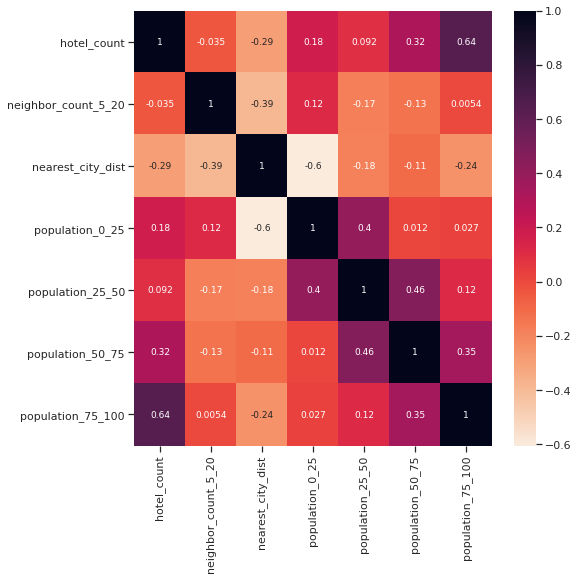

In [27]:
import matplotlib

plt.figure(figsize=(8,8))
cmap = matplotlib.cm.get_cmap('rocket_r')  # Invert color map such that dark => high
sns.heatmap(scaled_munro.corr(), annot=True, cmap=cmap)
plt.show()

None of the correlations is significant, i.e. above 0.8, so we do not remove any features.

## Multivariate linear regression

Another essential component to check before applying OLS is to make sure that our dependent variable is not highly skewed. In order to see if that is the case, we plotted the distribution of the Ascent Count. We notice that the distribution is right-skewed.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


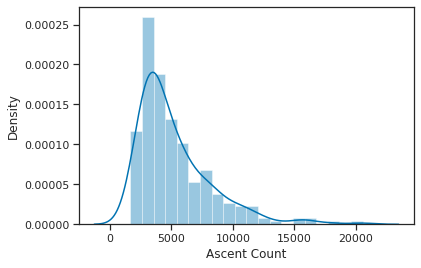

In [28]:
sns.distplot(munro['ascent_count'])
plt.xlabel('Ascent Count')
plt.show()

In order to fix this skew, we use log-transform Ascent Count. This yields a distribution which is less skewed and which looks approximately normal.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


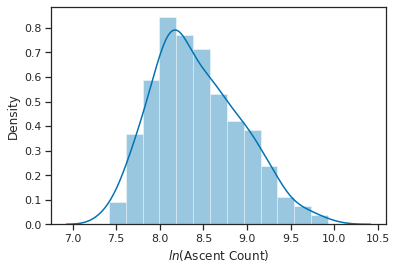

In [29]:
sns.distplot(np.log(munro['ascent_count']))
plt.xlabel('$ln$(Ascent Count)')
plt.show()

We will now apply ordinary least squares regression to the dataset. We will use each of the standardized features as regressors and the log-transformed Ascent Count as the target.

In [30]:
X = scaled_munro.copy()
X['intercept'] = 1  # consider intercept when fitting the model

model = sm.OLS(np.log(munro['ascent_count']), X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ascent_count   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     42.23
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           3.88e-40
Time:                        15:27:11   Log-Likelihood:                -102.93
No. Observations:                 282   AIC:                             221.9
Df Residuals:                     274   BIC:                             251.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
hotel_count            -0.1245    

We notice `population_25_50` has quite a high $p$-value of about 0.270. This might be due to multicollinearity with other population-related features.

In [48]:
X = scaled_munro.copy()
X['intercept'] = 1  # consider intercept when fitting the model
del X['population_25_50']

model = sm.OLS(np.log(munro['ascent_count']), X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ascent_count   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     49.02
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           9.62e-41
Time:                        15:35:17   Log-Likelihood:                -103.56
No. Observations:                 282   AIC:                             221.1
Df Residuals:                     275   BIC:                             246.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
hotel_count            -0.1298    

On applying OLS on the data with `population_25_50` excluded, we notice that we get a decent fit with and adjusted $R^2$ of 0.506. We also notice that the F-statistic of the fit is quite high too. In addition, we notice that all the features in model have a $p$-value within 0.01. This indicates the obtained coefficients are reliable.

Since the regressors are standardized and the target is log-transformed, we transform them to an interpretable format.

We are interested in the impact of a unit change in a regressor on the target.
The linear regression is of the form 
$$\beta_0 + \beta_1z^{(1)}+...=\ln(y)$$
where $z^{(i)}$ is the $i$-th regressor, standardised. To interpret the response in the target to a unit increase in the $i$-th regressor, we let $x^{(j)}=0\ (\forall j\neq i)$. Then we have 

$$\beta_0 + \beta_iz^{(i)}=\ln(y)$$

Now
$$\beta_i\left(z_2^{(i)} - z_1^{(i)}\right) = \ln(y_2) - \ln(y_1)$$

Now since $z^{(i)}=\frac{x^{(i)}-\overline{x}^{(i)}}{\sigma_{x^{(i)}}}$ due to standardisation, we may rewrite the above as

$$\beta_i\frac{x_2^{(i)} - x_1^{(i)}}{\sigma_{x^{(i)}}} = \ln(y_2) - \ln(y_1)$$

Now we are interested in a unit increase in the regressor $x^{(i)}$, so then $x_2^{(i)} - x_1^{(i)}=1$ so that

$$\frac{\beta_i}{\sigma_{x^{(i)}}} = \ln(y_2) - \ln(y_1) = \ln\left(\frac{y_2}{y_1}\right)$$

which upon exponentiation and applying the laws of logarithms becomes

$$\exp\left(\frac{\beta_i}{\sigma_{x^{(i)}}}\right) = \frac{y_2}{y_1}$$

which we may rewrite as 

$$\exp\left(\frac{\beta_i}{\sigma_{x^{(i)}}}\right) - 1 = \frac{y_2}{y_1} - 1 = \frac{y_2-y_1}{y_1}$$

Thus, a unit increase in an original feature leads to a $100\left[\exp\left(\frac{\beta_i}{\sigma_{x^{(i)}}}\right) - 1\right]$ percent increase in Ascent Count.


We transform the coefficients accordingly:

In [49]:
coefficients = results.params.to_dict()

CIs = results.conf_int().T.to_dict()  # TODO okay? 

for key in coefficients.keys():
    if key == 'intercept':
        continue
    std = munro_subset[key].std()
    b = coefficients[key]
    CI = CIs[key]
    response = 100 * (np.exp(b / std) - 1)
    response_lo = 100 * (np.exp(CI[0] / std) - 1)
    response_hi = 100 * (np.exp(CI[1] / std) - 1)
    print(f'{key:22}{response:10.6f}%\t[{response_lo:6f}, {response_hi:6f}]')

hotel_count            -0.646347%	[-0.924827, -0.367084]
neighbor_count_5_20    -1.194279%	[-1.700515, -0.685435]
nearest_city_dist      -0.504991%	[-0.888305, -0.120195]
population_0_25         0.002555%	[0.001302, 0.003809]
population_50_75        0.000031%	[0.000023, 0.000040]
population_75_100       0.000035%	[0.000028, 0.000043]


The most dominant feature is neighbor_count_5_20. Every extra neighboring Munro within 5-20km reduces the Ascent Count by ~1.2%. The other dominant features are the number of hotels, wherein each extra hotel reduces Ascent Count by ~0.65%, and the distance to the nearest city, such that each extra kilometer distance leads to a ~0.5% decrease in Munro popularity. 

The importance of hotel count is somewhat surprising. This may indicate that hotel count is a proxy for another variable that we did not include in our model.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


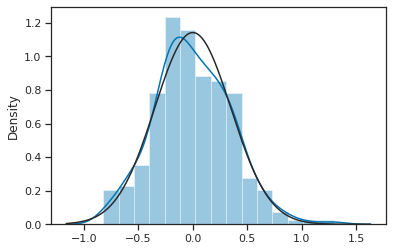

In [33]:
# Plot the distribution of residuals
sns.distplot(results.resid, fit=stats.norm)
plt.savefig('residuals_dist.pdf', bbox_inches='tight')
# plt.title('Distribution of Residuals')
plt.show()

Errors are approximately normally distributed. This is nice to see, since this is an assumption of linear regression.

### Inspect heteroskedasticity

In order to see if the dataset exhibits heteroskedasticity, we plot the residuals of our fit against the predictions.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


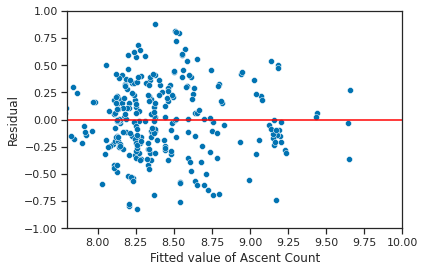

In [34]:
fig, ax = plt.subplots()
ax.set_ylabel('Residual')
ax.set_xlabel('Fitted value of Ascent Count')
y_hat = results.predict(X)

sns.scatterplot(y_hat, results.resid)

sns.lineplot(x=list(range(7, 11)), y=0, color='red')
plt.xlim(7.8, 10)
plt.ylim(-1, 1)
plt.show()

We notice that the variance of the residuals does not increase with the fitted value. This shows that there is no heteroskedasticity.

## 3. Question – Cluster Munros according to their features

We will now move to our next question, which is to cluster Munros according to the independent features. This may help us discover a sub-structure within the datset and help us understand it better.

## PCA

Before performing K-Means Clustering, we need to reduce the number of independent vectors. This is because as a distance-based method, K-Means suffers from the curse of dimensionality and will perform poorly when applied to a vast dataset. Hence, we perform PCA on the dataset.

In [35]:
standardized_data = StandardScaler().fit_transform(munro_subset)
df_clusters = pd.DataFrame(standardized_data, index=munro_subset.index, columns=munro_subset.columns)

pca = PCA().fit(df_clusters)

### Scree plot

To determine the appropriate number of PCA components to be used, we will be plotting a scree plot to find the knee.

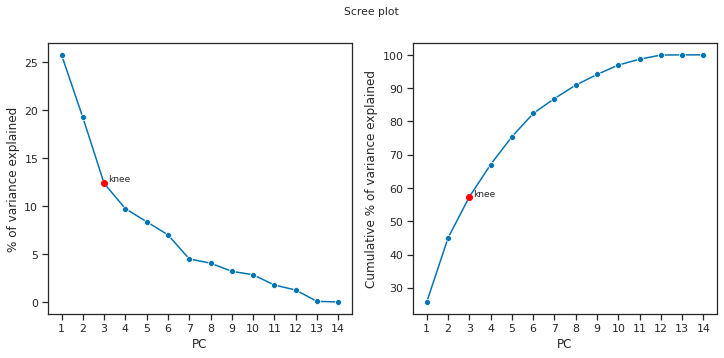

In [36]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
y = pca.explained_variance_ratio_ * 100
x = range(1, len(y)+1)

sns.set_style("ticks")

# Scree plot (ax1)
sns.lineplot(x=x, y=y, marker='o', ax=ax1)
ax1.set_ylabel('% of variance explained')
ax1.set_xticks(x)
ax1.set_xlabel('PC')

# Mark the knee
knee = 3
# ax1.plot(knee, y[knee-1], color='red', marker='o', label='knee')

# Cumulative scree plot (ax2)
y2 = y.cumsum()
sns.lineplot(x=x, y=y2, marker='o', ax=ax2)
ax2.set_ylabel('Cumulative % of variance explained')
ax2.set_xticks(x)
ax2.set_xlabel('PC')

# Mark the knee
ax1.annotate('knee', (knee + 0.2, y[knee-1] + 0.2))
ax1.plot(knee, y[knee-1], color='red', marker='o')
ax2.annotate('knee', (knee + 0.2, y2[knee-1] + 0.2))
ax2.plot(knee, y2[knee-1], color='red', marker='o')

plt.suptitle('Scree plot')
plt.show()

The scree plot shows that the first 3 principal components help explain a considerable amount of variance. Using the cumulative plot, we see that this is about 60% of the variance. The knee is indicated in red.

### PCA with fewer components

Using the results above, we transform the dataset and only include the first 3 principal components.

In [37]:
pc_scores = [f'PC{i+1}' for i in range(knee)]

In [38]:
# Reapply PCA to work with cleaner data
pca = PCA(n_components=knee)

# Transform original data using PC scores
transformed_values = pca.fit_transform(df_clusters)
df_transformed = pd.DataFrame(transformed_values, columns=pc_scores)

Having removed the less relevant PCs, we now interpret the relevant prinicipal components' loadings:

In [39]:
df_pca = pd.DataFrame(pca.components_, columns=df_clusters.columns, index=pc_scores).T

cm = sns.diverging_palette(240, 10, as_cmap=True)
df_pca.style.background_gradient(cmap=cm).set_precision(2)

,PC1,PC2,PC3
altitude,-0.15,-0.05,-0.04
bb_count,-0.46,0.17,-0.04
hotel_count,-0.29,0.35,-0.32
hostel_count,-0.46,-0.05,0.20
cottage_count,-0.40,-0.30,-0.19
camping_count,-0.40,-0.30,-0.19
neighbor_count_0_5,-0.07,-0.22,0.10
neighbor_count_5_20,-0.07,0.09,0.49
nearest_city_dist,0.21,-0.37,-0.37
nearest_city_population,-0.07,-0.19,-0.27


- PC1: People from the nearest city, which is 25 - 75km away, come to a Munro but they do not stay at an accommodation. There's a slight preference for shorter Munros. -> "Preferred by Locals".
- PC2: People from cities up to 100km away come to a Munro and they stay at a bed and breakfast, but preferably at a hotel. They seek a Munro which is further away from a nearby city. There slightly prefer if there are neighboring Munros nearby, but not too close by (neighbor_count_0_5 negative). -> "Preferred by people Going on a Trip"
- PC3: People from a nearby city within 25 km of the Munro come to a cheaper accommodation (hostel). They prefer if there are other Munros in the area (neighbor_count_5_20 positive). They too prefer to be further away from a nearby city. -> "Preferred by Serious Local Hikers"

In [40]:
# Inspect the shape of data after transformation
# sns.pairplot(df_transformed)
# plt.show()

To determine the appopriate number of clusters, we inspect inertia of K-Means model with clusters ranging from 2 to 20.

In [41]:
inertia = []
for i in range(2, 20):
    K_means_sklearn_model = KMeans(n_clusters=i, random_state=42)
    K_means_sklearn_model.fit(df_transformed)
    inertia.append(K_means_sklearn_model.inertia_)

We will now be plotting the inertia values against the list of number of clusters used above.

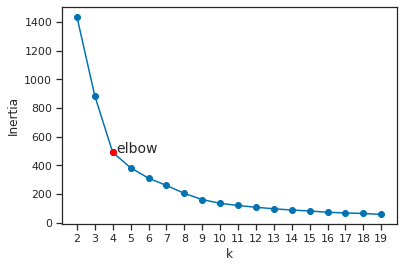

In [42]:
plt.plot(list(range(2,20)), inertia, '-o')
plt.xticks(list(range(2,20)))
plt.ylabel('Inertia')
plt.xlabel('k')
elbow = 4
plt.plot(elbow, inertia[elbow-2], color='red', marker='o', label='elbow')
plt.annotate('elbow', (elbow + 0.2, inertia[elbow-2] + 0.2), size=14)
plt.show()

There is a clear elbow at $k=4$. Thus, the optimal number of clusters is 4. We now perform K-Means. Since we cluster in 3 dimensions, we plot the predictions on a 3D plot and indicate the clusters' centroids.

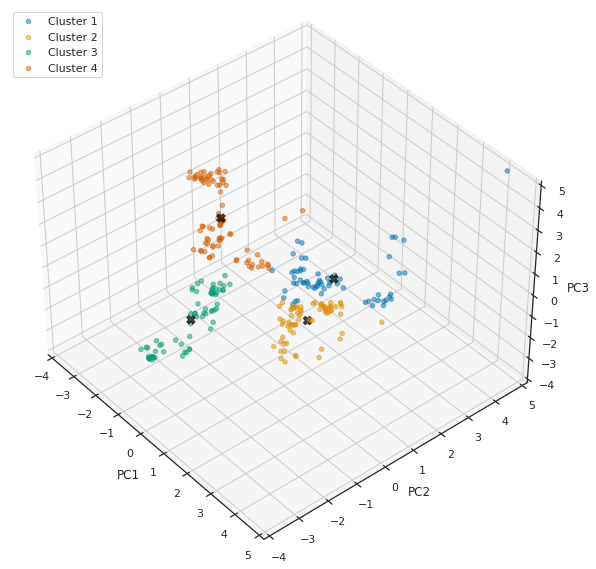

In [43]:
# Set random seed for reproducibility
np.random.seed(42)

elbow = 4
K_means_sklearn_model = KMeans(n_clusters=elbow, random_state=42)
K_means_sklearn_model.fit(df_transformed)
prediction = K_means_sklearn_model.predict(df_transformed)
centres = K_means_sklearn_model.cluster_centers_

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Plot scatter plots
df_transformed['prediction'] = prediction
for i in range(0,4):
    df_sub = df_transformed.loc[df_transformed['prediction'] == i]
    ax.scatter(df_sub['PC1'], df_sub['PC2'], df_sub['PC3'], cmap='cool', alpha=0.5, label=f'Cluster {i+1}')

# Plot cluster centres
ax.scatter(centres[:,0], centres[:,1], centres[:,2], marker='X', color='black', s=70, alpha=0.7)

ax.legend(loc='upper left')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.set_xlim(-4,5)
ax.set_ylim(-4,5)
ax.set_zlim(-4,5)

# Set angle of view
ax.azim = -40
ax.elev = 40

plt.show()

The clusters above look good!

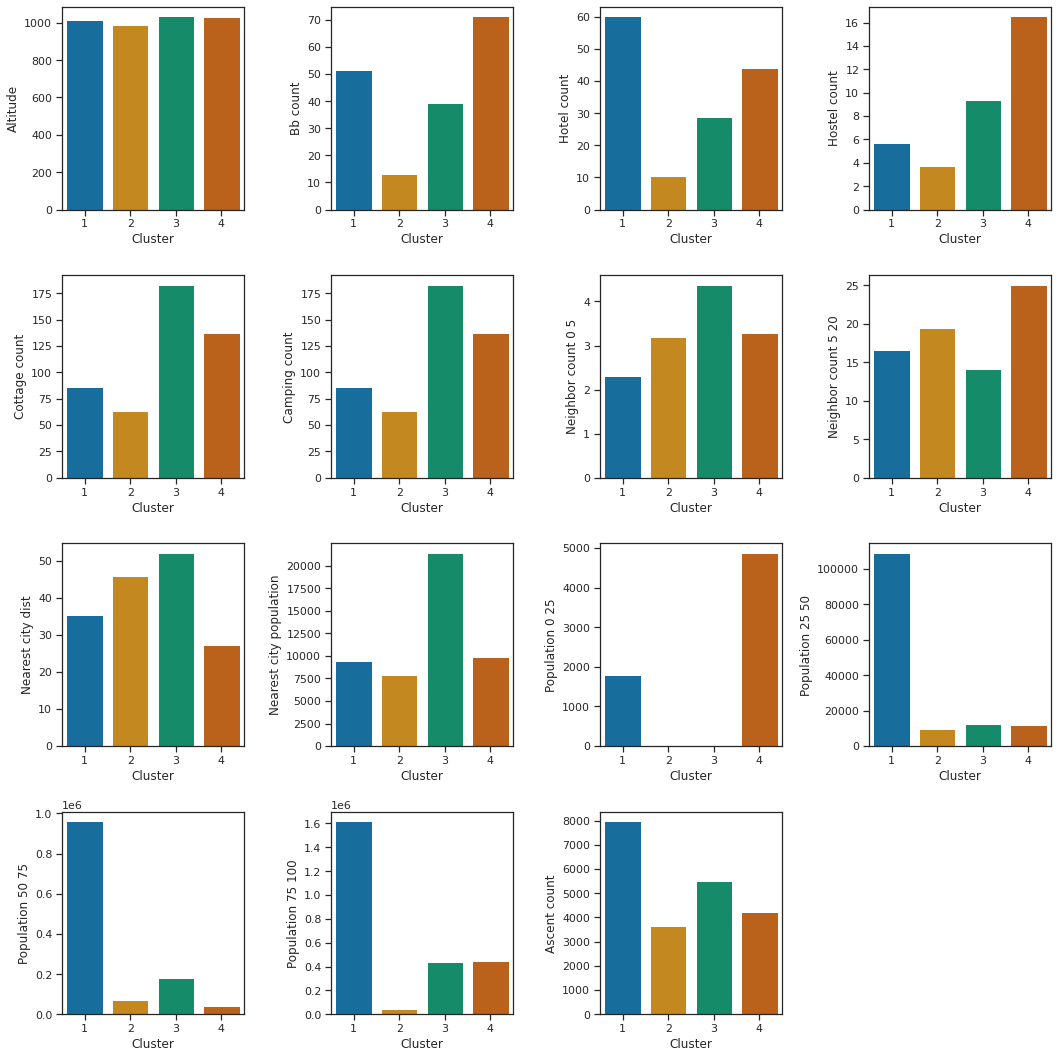

In [44]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(15,15))

df_temp = munro_subset.copy()
df_temp['clusters'] = prediction + 1
df_temp['ascent_count'] = munro['ascent_count']

# For each munro, calculate the mean of each feature
df_temp.groupby('clusters').mean()

for i, feature in enumerate(df_temp.columns[df_temp.columns != 'clusters']):
    row = i // 4
    col = i % 4
    ax = axes[row][col]    
    sns.barplot(x='clusters', y=feature, data=df_temp, ax=ax, ci=None)
    ax.set_ylabel(feature.replace('_', ' ').capitalize())
    ax.set_xlabel('Cluster')

# Delete 
fig.delaxes(axes[3][3])

fig.tight_layout(pad=2)
plt.show()

In [45]:
# Used to find Munro examples
# munro.loc[df_temp['clusters'] == 4].sort_values('ascent_count', ascending=False)['name'].head(2)

- Cluster 1:
    - The average Munro in cluster 1 has ~2000 inhabitants within 25km, while the nearest city has ~10,000 inhabitants and is ~35km away. This cluster has the largest population 25-100km away out of all clusters. At about 60, it also has the largest number of hotels. It also has a fair amount of bed and breakfast accomodations (about 50). At slightly above 2 Munros, it has the lowest the number of neighbouring Munros. For example Ben Lomond and Ben Lawers fall in this category.
    - Since there are no neighbouring Munros and there are a lot of hotels near the Munro, we can say that these are fairly "exclusive" Munros which are suitable for visitors from a larger city. Making them fairly popular.

- Cluster 2:
    - The average Munro in cluster 2 does not have a large city within 100km. The nearest city is about ~45km away with a population slightly higher than ~7,500. The dominant accommodation type for this cluster are cottages and camping, and there are relatively few B&Bs, hotels and hostels. It has about 25 neighboring Munros within 20km. For example Mount Keen and Ben Hope belong to this cluster.
    - A region with a fair amount neighbouring Munros, with not many accomodation facilities and are also further away from any major city. Making them fairly less popular.

- Cluster 3:
    - For the average Munro in cluster 3, the closest city is more than 50km away, but has ~20,000 people – the most across all clusters. It has the largest number of cottages and campings out of all clusters, with relatively fewer B&Bs, hotels and hostels. At more than 4, it also has the largest number of neighboring Munros within 5km. For example Cairn Gorm and The Cairnwell belong here.
    - The visitors of this Munro perhaps wish to visit more Munros during their trip. This cluster has the highest nearest city population, so perhaps inhabitants of the nearby city are "regulars". The visitors also perhaps wish to visit more Munros during their trip and stay at a cottage or a camping site. At ~6000 ascents, these are fairly popular.

- Cluster 4:
    - The average Munro in cluster 4 has the largest number of people within 25km across all clusters, but relatively few people beyond that. The nearest city is ~25km away and has a population of about 10,000. Other larger settlements lie beyond 75km away. The dominant accommodation type are B&Bs and hostels. At almost 25km, it has the largest number of neighboring Munros within 5-20km. An example is Ben Nevis or Stob Dearg (Buachaille Etive Mor).
    - Quite close to a fairly populated town but no other cities nearby. These Munros have a decent amount of cheap accomodation (hostel) but no other cities. Isolated but within 25 km of a town.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ad6e5521-2329-4ba2-9ce8-c0f71fb15c68' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>